# Model to Evaluate

In [1]:
base_file = "bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes"
# base_file = "bestmodel_pretrained_unfrozen_20ng_s23_noOF_logtheta10_simscale10_5prototypes"

file_path_imdb = "../data/movie_checkpoints/labeled_percentage_sweep/"
file_path_20ng = "../data/20ng_checkpoints/labeled_percentage_sweep/"

In [2]:
is_movies = 'movie' in base_file
if is_movies:
    fp = file_path_imdb
else:
    fp = file_path_20ng
models_to_eval = {}

if is_movies:
    base_model_params = "../data/pretrained_models/pretrained_movies_noOF.pt"
else:
    base_model_params = "../data/pretrained_models/pretrained_20ng_noOF.pt"

for percentage in [0.5, 0.25, 0.1, 0.05, 0.01]:
    models_to_eval[percentage] = fp + base_file + "_lp"+str(int(percentage*100))+".pt"
# naming convention doesn't follow the above arithmetic 
models_to_eval[0.005] = fp + base_file + "_lp05.pt"
models_to_eval[0.001] = fp + base_file + "_lp01.pt"

In [3]:
models_to_eval

{0.5: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp50.pt',
 0.25: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp25.pt',
 0.1: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp10.pt',
 0.05: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp5.pt',
 0.01: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp1.pt',
 0.005: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_logtheta10_simscale10_5prototypes_lp05.pt',
 0.001: '../data/movie_checkpoints/labeled_percentage_sweep/bestmodel_pretrained_unfrozen_movies_s23_noOF_log

### Installs, Imports, and Pyro Setup 

In [4]:
import pickle as pkl
from typing import List
if is_movies:
    from imdb_dataset import PairwiseData, DocumentPairData
else:
    from dataset import PairwiseData, DocumentPairData
from model import Encoder, Decoder, ProdLDA, custom_elbo
import math

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from ctt.clean import kitchen_sink

import pyro
from pyro import poutine
import pyro.distributions as dist
# import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam
import torch.nn.functional as F
from scipy.io import loadmat

import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pandas as pd
from pandas.plotting import table 
import matplotlib.pyplot as plt
import wandb
import umap
import umap.plot
import sklearn.datasets
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score



/home/dsaad/.conda/envs/updated_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25

In [6]:
pyro.distributions.enable_validation(True)

In [7]:
pyro.set_rng_seed(0)

# Setup

In [8]:
# Data
PAIR_PERCENTAGE = 1.0
NUM_WORKERS = 0

# Dropout rate
NUM_TOPICS = 50
NUM_PROTOTYPES = 5
EMBED_DIM  = 64
HIDDEN_DIM = 128
DROPOUT_RATE = 0.2

# Training
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 25
TEST_FREQUENCY = 1
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
OBS_SAMPLES = 10

latest_plotted_p = torch.zeros(NUM_PROTOTYPES, NUM_TOPICS)

## Data

In [9]:
def get_data(pair_percentage=1.0):
    # pairwise data
    pwd = PairwiseData()
    train_pairs, val_pairs, test_pairs = [pwd.get_pairs_table(d) for d in [pwd.train, pwd.val, pwd.test]]

    # datasets
    data_train, data_val, data_test = [
        DocumentPairData(bows=pwd.bows, index_table=ix_table, prob=pair_percentage)
        for ix_table in [train_pairs, val_pairs, test_pairs]
    ]

    # dataloaders
    dl_train = DataLoader(data_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
    dl_val = DataLoader(data_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
    dl_test = DataLoader(data_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
    
    return pwd, dl_train, dl_val, dl_test

## Evaluate 

### Get base pretrained model weights

In [10]:
base_model_dict = torch.load(base_model_params)
base_betas = torch.softmax(base_model_dict['model']['decoder.beta.weight'].cpu().T, axis=-1)

In [11]:
def compute_kld(beta_before, beta_after, epc=1e-8):
  if beta_before.shape[-1] != beta_after.shape[-1]:
    raise ValueError("Word Distributions must be the same length")

  return (beta_before * np.log(epc+(beta_before/beta_after))).sum(axis=-1)

In [12]:
def evaluate(etm, test_loader, device): 
    etm.eval()
    
    # initialize loss accumulator
    logits_list = []
    labels_list = []
    
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        x_a = x['a'].to(device).squeeze()
        x_b = x['b'].to(device).squeeze()
        x_label = x['label'].to(device).type(torch.float32)
        x_observed = x['observed'].to(device).type(torch.bool)
        
        # generate reconstruction of batch documents and move to cuda if designated
        with torch.no_grad():
            recon_x_a = etm.reconstruct_doc(x_a)
            recon_x_b = etm.reconstruct_doc(x_b)
            logits = etm.guide(x_a, x_b, x_label, x_observed)

        x_label = x_label.cpu()
        logits_list.append(logits.cpu())
        labels_list.append(x_label)
        
#         # do something with the log odds
    return torch.concat(logits_list), torch.concat(labels_list)

EVALUATING 0.5


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.25


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.1


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.05


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.01


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.005


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


EVALUATING 0.001


/local_scratch/pbs.589815.pbs02/ipykernel_138195/1644804242.py:61: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df.style.hide_index()


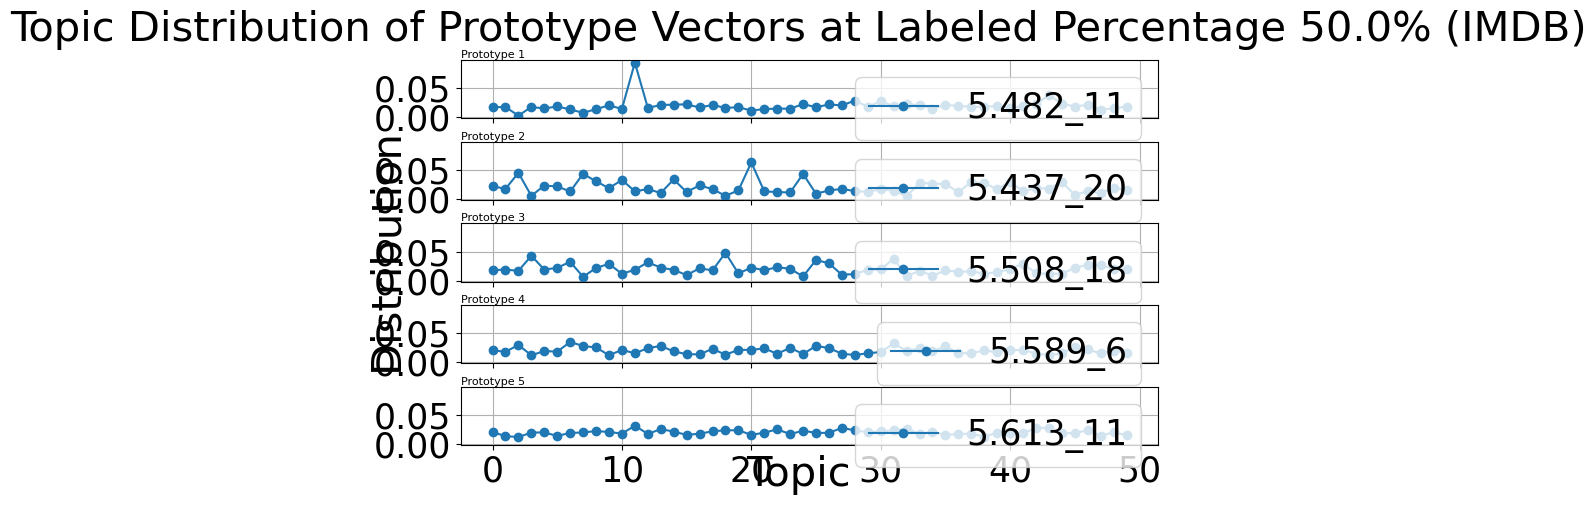

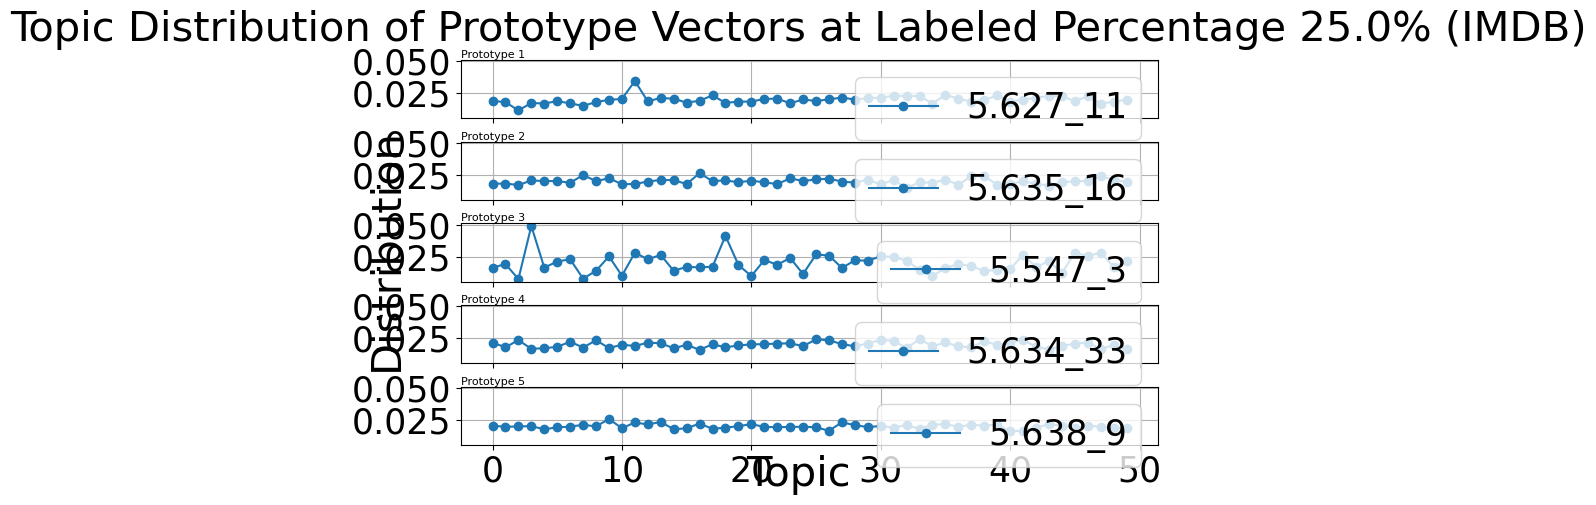

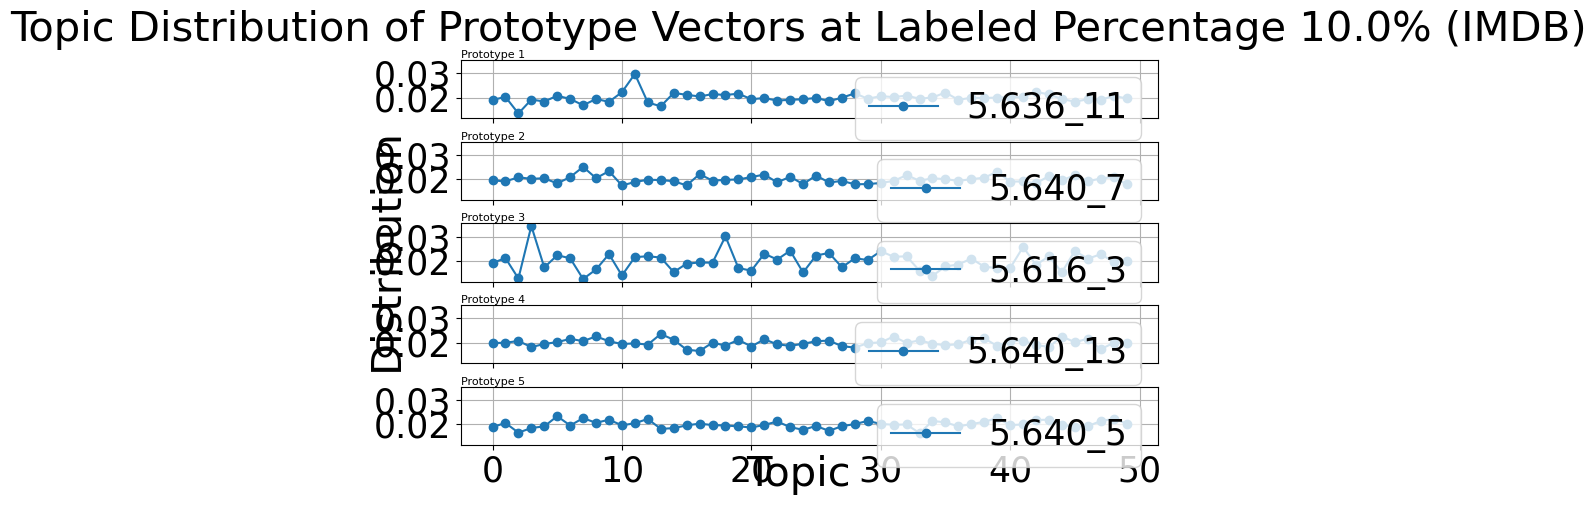

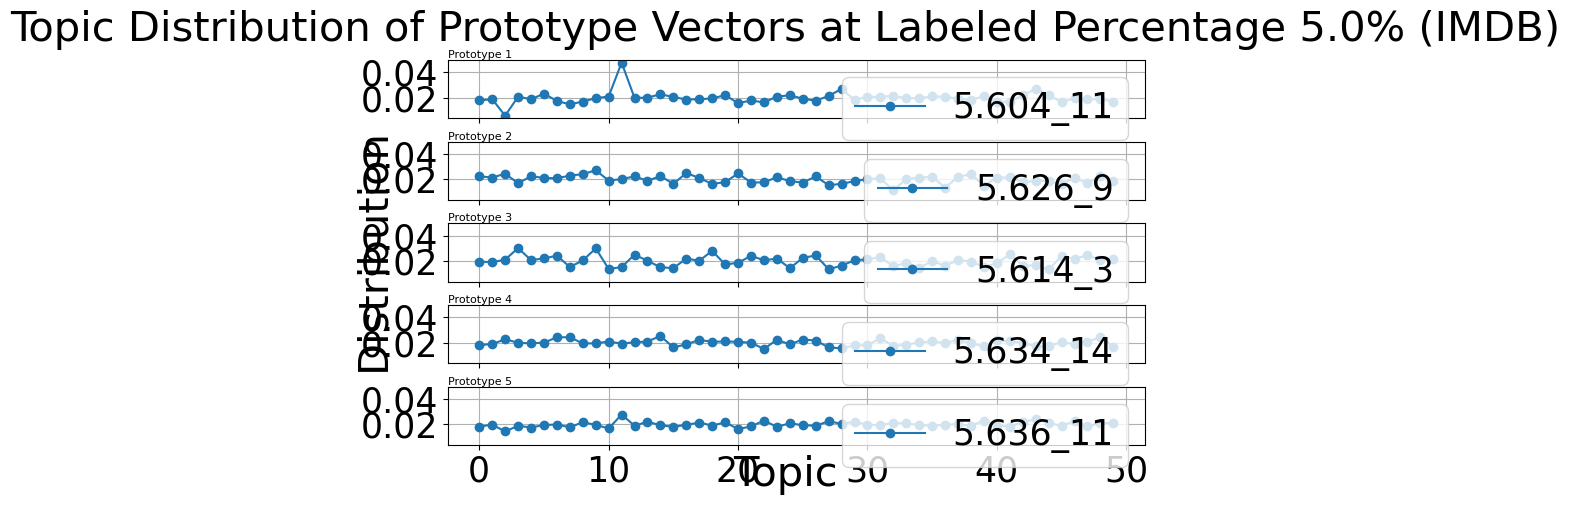

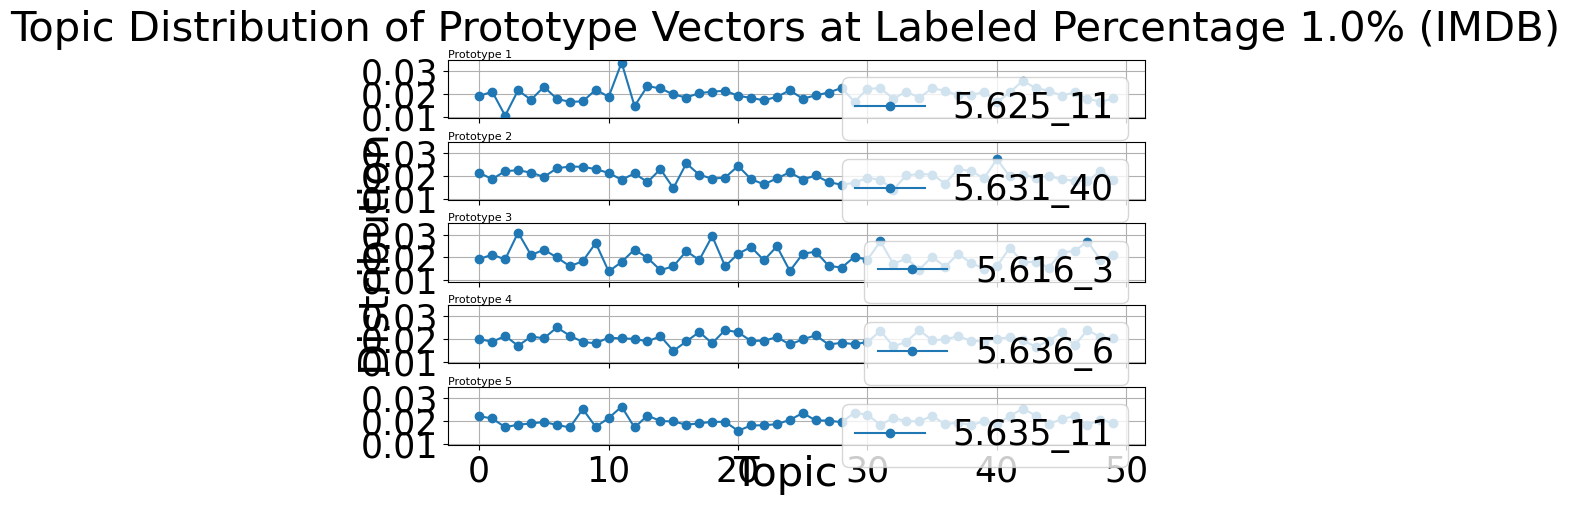

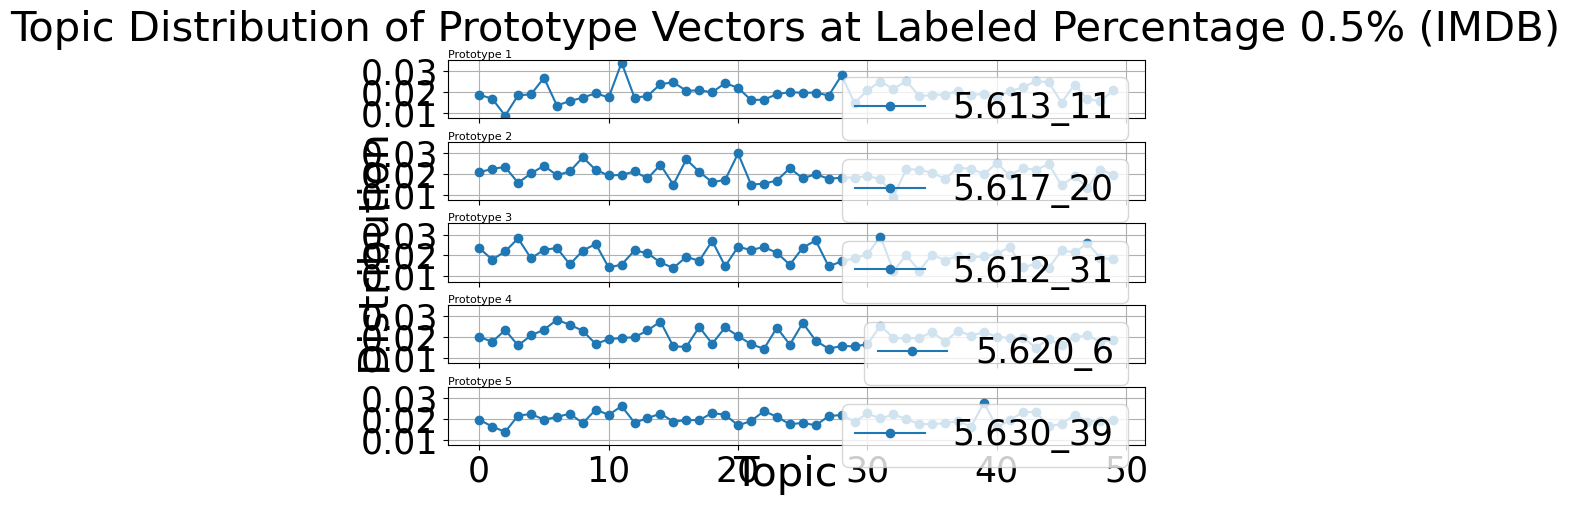

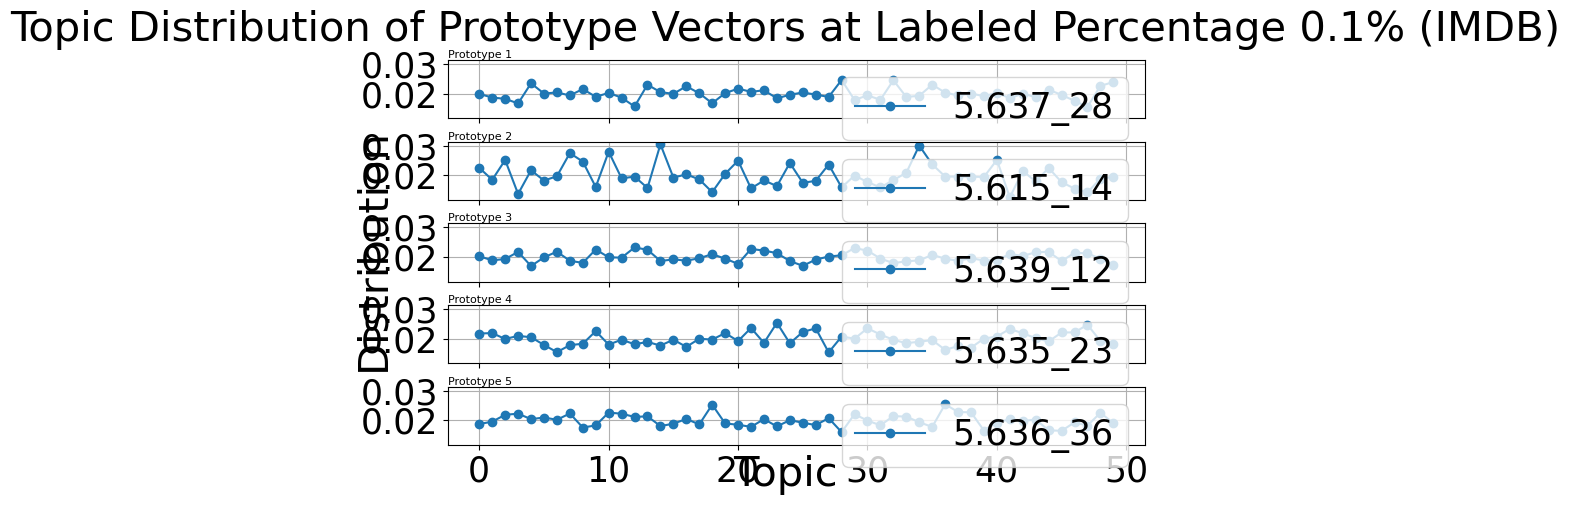

In [13]:
sweep_accuracy = {}
sweep_auroc = {}
sweep_wordlists = {}
sweep_distributions = {}
sweep_topic_kld = {}
sweep_topic_kld_means = {}
baseline_accuracy = 0;

for labeled_percentage in models_to_eval:
    print(f"EVALUATING {labeled_percentage}")
    pyro.set_rng_seed(0)
    
    pwd, dl_train, dl_val, dl_test = get_data(labeled_percentage)

    pyro.clear_param_store()
    topic_model = ProdLDA(pwd.vocab_size, NUM_TOPICS, NUM_PROTOTYPES, HIDDEN_DIM, DROPOUT_RATE, DEVICE, frozen=True).to(DEVICE)
    saved_model_dict = torch.load(models_to_eval[labeled_percentage], map_location=DEVICE)
    topic_model.load_state_dict(saved_model_dict['model'])
    
    with torch.no_grad():
        logits, label = evaluate(topic_model, dl_test, device=DEVICE)
        logits = torch.sigmoid(logits)
    
    srt_ix = logits.argsort()
    logits_srt = logits[srt_ix]
    logit_thresholds = logits_srt.unique().numpy()[-1::-100]
    accuracy = {}
    for threshold in logit_thresholds:
        preds = logits>threshold
        acc = accuracy_score(label, preds)
        accuracy[threshold] = acc
    acc_max = max(accuracy.values())
    sweep_accuracy[labeled_percentage] = acc_max
    if baseline_accuracy == 0:
        baseline_accuracy = accuracy_score(label, torch.zeros_like(label))
    
    auroc = roc_auc_score(label,logits)
    sweep_auroc[labeled_percentage] = auroc
    
    p = pyro.param('p').detach().cpu()
    phi = torch.softmax(p, axis=-1)    
    tok2ix = pwd.vectorizer.vocabulary_
    ix2tok = {v:k for k,v in tok2ix.items()}
    with torch.no_grad():
        phi_decoded = topic_model.decoder(phi.to(DEVICE))
    top_term_ixs = phi_decoded.argsort(axis=-1, descending=True)[:,:45]

    topic_terms = []
    for jx, topic in enumerate(top_term_ixs):
        # print(f"THEME {jx+1}")
        terms = [(ix2tok[ix.item()]) for ix in topic]
        # for term in terms:
            # print(term)
        topic_terms.append(terms)
        # print()

    df = pd.DataFrame(topic_terms)
    df = df.transpose()
    # df.columns = ["Theme A", "Theme B", "Theme C", "Theme D", "Theme E", "Theme F", "Theme G"]
    df.columns = ["Theme A", "Theme B", "Theme C", "Theme D", "Theme E"]
    df.style.hide_index()
    sweep_wordlists[labeled_percentage] = df
    
    fig, ax = plt.subplots(nrows=len(phi), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.4)
    fig.set_size_inches(9,5)
    if is_movies:
        fig.suptitle(f"Topic Distribution of Prototype Vectors at Labeled Percentage {labeled_percentage * 100}% (IMDB)")
    else:
        fig.suptitle(f"Topic Distribution of Prototype Vectors at Labeled Percentage {labeled_percentage * 100}% (20NG)")

    fig.supxlabel("Topic")
    fig.supylabel("Distribution")
    for ix, v in enumerate(phi):
        ax[ix].plot(v, 'o-', label=f"{-torch.sum(v*v.log2()).item():0.3f}_{v.argmax().item()}")
        ax[ix].grid()
        ax[ix].set_title(f"Prototype {ix+1}", loc="left", fontdict={'fontsize': 8,'fontweight' : "normal", 'verticalalignment': 'top', 'horizontalalignment': "left"})
        ax[ix].legend(loc=1)

    if is_movies:
        if labeled_percentage*100 >= 1:
            plt.savefig(f'./figures/prototype_distribution_{int(labeled_percentage*100)}_imdb', dpi=500, bbox_inches="tight")
        elif labeled_percentage == 0.005:
            plt.savefig(f'./figures/prototype_distribution_05_imdb', dpi=500, bbox_inches="tight")
        elif labeled_percentage == 0.001:
            plt.savefig(f'./figures/prototype_distribution_01_imdb', dpi=500, bbox_inches="tight")
    else:
        if labeled_percentage*100 >= 1:
            plt.savefig(f'./figures/prototype_distribution_{int(labeled_percentage*100)}_20ng', dpi=500, bbox_inches="tight")
        elif labeled_percentage == 0.005:
            plt.savefig(f'./figures/prototype_distribution_05_20ng', dpi=500, bbox_inches="tight")
        elif labeled_percentage == 0.001:
            plt.savefig(f'./figures/prototype_distribution_01_20ng', dpi=500, bbox_inches="tight")
    sweep_distributions[labeled_percentage] = fig
    
    # trained_betas = torch.softmax(saved_model_dict['model']['decoder.beta.weight'].cpu().T, axis=-1)
    trained_betas = torch.softmax(topic_model.beta().cpu(), axis = -1)
    cost_matrix = compute_kld(base_betas[None], trained_betas[:,None])
    assignment = scipy.optimize.linear_sum_assignment(cost_matrix)
    realigned_trained_betas = trained_betas[assignment[1]]
    
    kld = compute_kld(base_betas, realigned_trained_betas)
    kld_mean = kld.mean().item()
    
    sweep_topic_kld[labeled_percentage] = kld
    sweep_topic_kld_means[labeled_percentage] = kld_mean

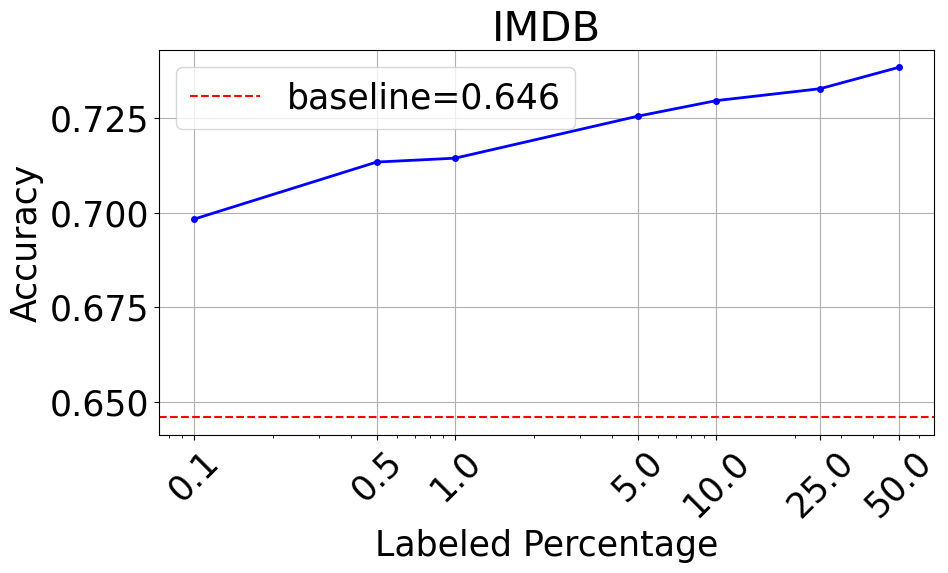

In [14]:
percentages = list(sweep_accuracy.keys())
percentages = [i * 100 for i in percentages]
accuracy = list(sweep_accuracy.values())
acc_rand = accuracy_score(label, torch.randint_like(label, 2))
acc_max_ix = np.argmax(accuracy)

fig, ax = plt.subplots(1,1)

ax.plot(percentages, accuracy, 'bo-', linewidth=2, markersize = 4)
ax.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'baseline={baseline_accuracy:0.3f}')
# plt.ylim(0.5)
ax.grid()
ax.semilogx()
ax.set_xticks(percentages)
ax.set_xticklabels(percentages,rotation=45)
ax.legend(loc=2)
if is_movies:
    ax.set_title("IMDB")
else:
    ax.set_title("20NG")
ax.set_xlabel("Labeled Percentage")
ax.set_ylabel("Accuracy")

img_title = 'accuracy_vs_percent_'
if is_movies:
    img_title += 'imdb'
else:
    img_title += '20ng'

plt.savefig('./figures/' + img_title, dpi=500, bbox_inches="tight")

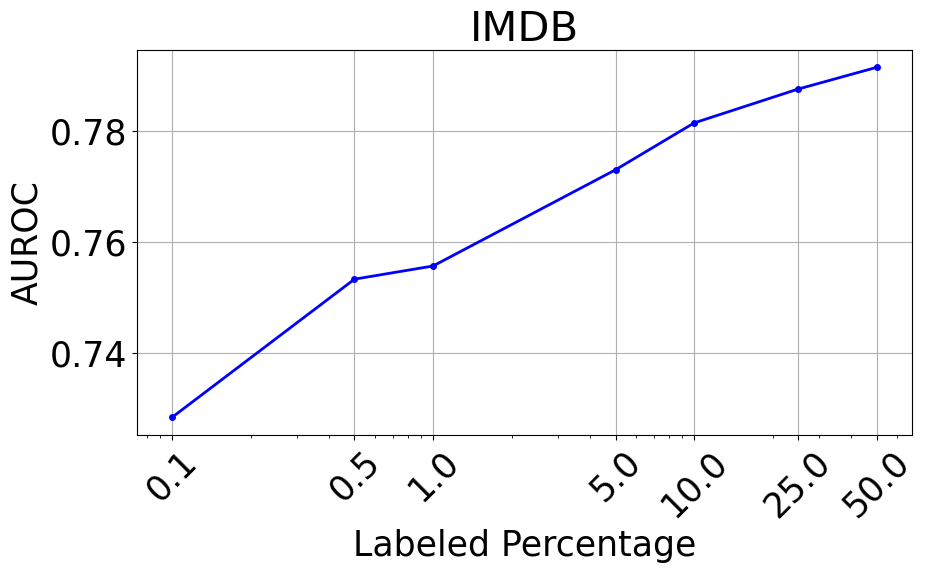

In [15]:
fig, ax = plt.subplots(1,1)

aurocs = list(sweep_auroc.values())
ax.plot(percentages, aurocs, 'bo-', linewidth=2, markersize = 4)
# plt.ylim(0,1)
ax.grid()
ax.semilogx()
ax.set_xticks(percentages)
ax.set_xticklabels(percentages,rotation=45)
# plt.legend(loc=4)
if is_movies:
    ax.set_title("IMDB")
else:
    ax.set_title("20NG")
ax.set_xlabel("Labeled Percentage")
ax.set_ylabel("AUROC")

img_title = 'auroc_vs_percent_'
if is_movies:
    img_title += 'imdb'
else:
    img_title += '20ng'

plt.savefig('./figures/' + img_title, dpi=500, bbox_inches="tight")

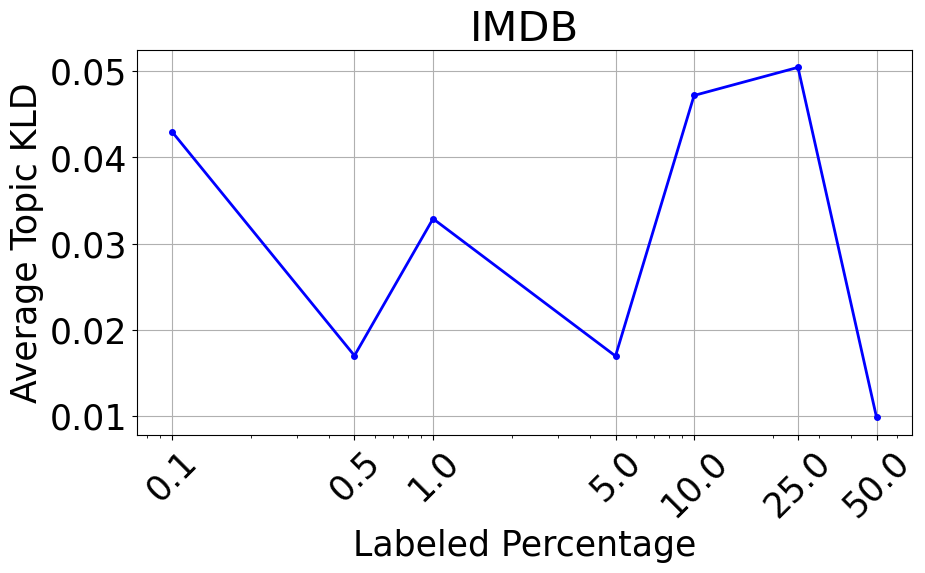

In [16]:
fig, ax = plt.subplots(1,1)

klds = list(sweep_topic_kld_means.values())
ax.plot(percentages, klds, 'bo-', linewidth=2, markersize = 4)
# plt.ylim(0,1)
ax.grid()
ax.semilogx()
ax.set_xticks(percentages)
ax.set_xticklabels(percentages,rotation=45)
# plt.legend(loc=4)
if is_movies:
    ax.set_title("IMDB")
else:
    ax.set_title("20NG")
ax.set_xlabel("Labeled Percentage")
ax.set_ylabel("Average Topic KLD")

img_title = 'averagekld_vs_percent_'
if is_movies:
    img_title += 'imdb'
else:
    img_title += '20ng'

plt.savefig('./figures/' + img_title, dpi=500, bbox_inches="tight")

In [17]:
percentages = [percentage / 100 for percentage in percentages]

In [18]:
wordlist_percentages = {
    1.0: '100', 
    0.75: '75', 
    0.5: '50', 
    0.25: '25', 
    0.1: '10', 
    0.05: '5', 
    0.01: '1',
    0.005: '05',
    0.001: '01'}

In [19]:
wordlist_name = 'wordlist_'
if is_movies:
    wordlist_name += 'imdb_'
else:
    wordlist_name += '20ng_'

for p in percentages:
    # ax = plt.subplot(1,1,1, frame_on=False) # no visible frame
    # ax.xaxis.set_visible(False)  # hide the x axis
    # ax.yaxis.set_visible(False)  # hide the y axis
    # table(ax, sweep_wordlists[p].truncate(after=25), loc='center', cellLoc = 'center', colColours=['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey'])
    # plt.savefig('./figures/' + wordlist_name + wordlist_percentages[p] + '.png', dpi=500)
    print(p)
    print(sweep_wordlists[p][:10].to_latex(index=False))
    # print(sweep_wordlists[p][:10])
    # sweep_wordlists[p]

0.5
\begin{tabular}{lllll}
\toprule
    Theme A &    Theme B &    Theme C &     Theme D &    Theme E \\
\midrule
   confused &  fantastic &      badly & interesting &  potential \\
  potential &    amazing &      awful &     towards & characters \\
     fairly &     highly &     poorly &         bit &     trying \\
     climax &  excellent & ridiculous &    sequence &      point \\
   speaking & definitely &       poor &      ending &      takes \\
    shallow &  brilliant &  obviously &     strange &      seems \\
    changes &    perfect &     effort &        nice & ultimately \\
forgettable &  realistic &      avoid &    elements &   speaking \\
    manages &      great &      worse &        deal &        way \\
    tedious &     superb &    attempt &      inside &        odd \\
\bottomrule
\end{tabular}

0.25
\begin{tabular}{lllll}
\toprule
    Theme A &   Theme B &    Theme C &     Theme D & Theme E \\
\midrule
   somewhat &    people &       poor & interesting &   first \\
     m

/local_scratch/pbs.589815.pbs02/ipykernel_138195/2711757648.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sweep_wordlists[p][:10].to_latex(index=False))


In [20]:
sweep_wordlists[0.5]

,Theme A,Theme B,Theme C,Theme D,Theme E
0,confused,fantastic,badly,interesting,potential
1,potential,amazing,awful,towards,characters
2,fairly,highly,poorly,bit,trying
3,climax,excellent,ridiculous,sequence,point
4,speaking,definitely,poor,ending,takes
5,shallow,brilliant,obviously,strange,seems
6,changes,perfect,effort,nice,ultimately
7,forgettable,realistic,avoid,elements,speaking
8,manages,great,worse,deal,way
9,tedious,superb,attempt,inside,odd
